In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import numpy as np
import pickle

In [67]:
data = pd.read_excel('database.xlsx')

data = data.dropna()

X = data.filter(regex='^1')
y = data['Hemorragia(Sin hemorragia (1),  500 a 749 (2), 750-1500 (3), 1501-2000 (4), >2000 (5))']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val_test, y_train, y_val_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=2/3, random_state=42)

y_train -= 1
y_val -= 1
y_test -= 1

num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [70]:
print(y_train, y_val)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]] [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [56]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [69]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_pca, y_train, epochs=100, batch_size=32, validation_data=(X_val_pca, y_val), callbacks=[early_stopping])

Epoch 1/100
51/51 [==============================] - 1s 8ms/step - loss: 1.3422 - accuracy: 0.5646 - val_loss: 1.0245 - val_accuracy: 0.8182
Epoch 2/100
51/51 [==============================] - 0s 7ms/step - loss: 0.7873 - accuracy: 0.8361 - val_loss: 0.5957 - val_accuracy: 0.8615
Epoch 3/100
51/51 [==============================] - 0s 7ms/step - loss: 0.5525 - accuracy: 0.8491 - val_loss: 0.4938 - val_accuracy: 0.8615
Epoch 4/100
51/51 [==============================] - 0s 8ms/step - loss: 0.5008 - accuracy: 0.8491 - val_loss: 0.4659 - val_accuracy: 0.8615
Epoch 5/100
51/51 [==============================] - 0s 7ms/step - loss: 0.4836 - accuracy: 0.8491 - val_loss: 0.4543 - val_accuracy: 0.8615
Epoch 6/100
51/51 [==============================] - 0s 7ms/step - loss: 0.4782 - accuracy: 0.8491 - val_loss: 0.4471 - val_accuracy: 0.8615
Epoch 7/100
51/51 [==============================] - 0s 6ms/step - loss: 0.4743 - accuracy: 0.8491 - val_loss: 0.4432 - val_accuracy: 0.8615
Epoch 8/100
5

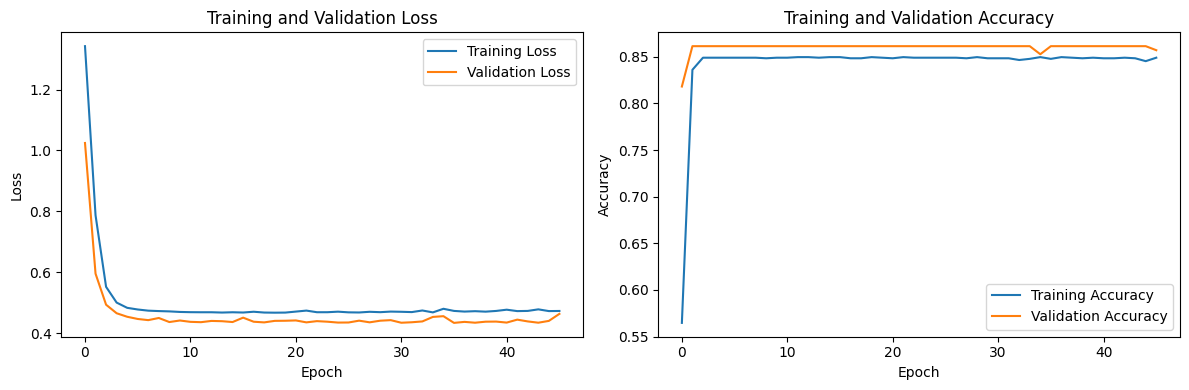

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.savefig('training_graphs.png')
plt.show()

In [72]:
model.save('trained_model.keras')
pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(pca, open('pca.pkl', 'wb'))

In [73]:
loaded_model = load_model('trained_model.keras')
loaded_scaler = pickle.load(open('scaler.pkl', 'rb'))
loaded_pca = pickle.load(open('pca.pkl', 'rb'))

AttributeError: 'Adam' object has no attribute 'build'

In [ ]:
def predict_output(input_data):
    input_data = np.array(input_data).reshape(1, -1)
    input_data_scaled = loaded_scaler.transform(input_data)
    input_data_pca = loaded_pca.transform(input_data_scaled)
    
    prediction = loaded_model.predict(input_data_pca)
    predicted_class = np.argmax(prediction, axis=1)
    return predicted_class[0]

In [ ]:
new_data = [...]
predicted_output = predict_output(new_data)
print(f'Predicted class: {predicted_output}')